In [2]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

### 이미지와 바 그래프 출력

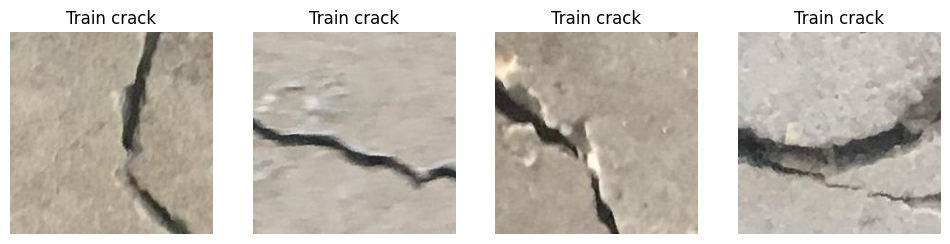

Train crack 총 이미지 수: 17650


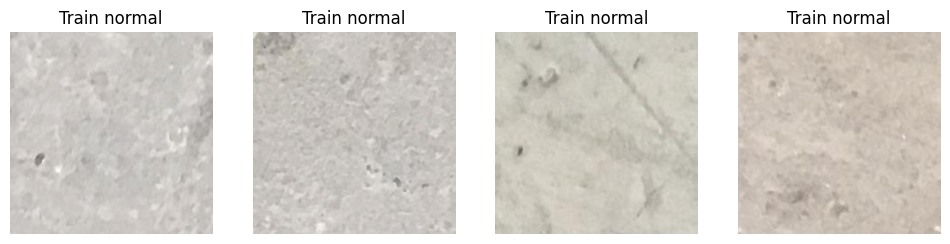

Train normal 총 이미지 수: 17900


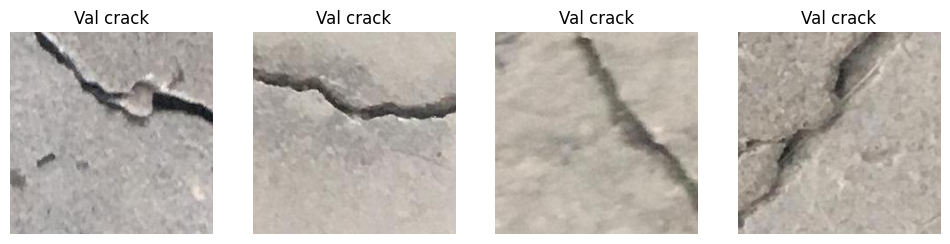

Val crack 총 이미지 수: 1600


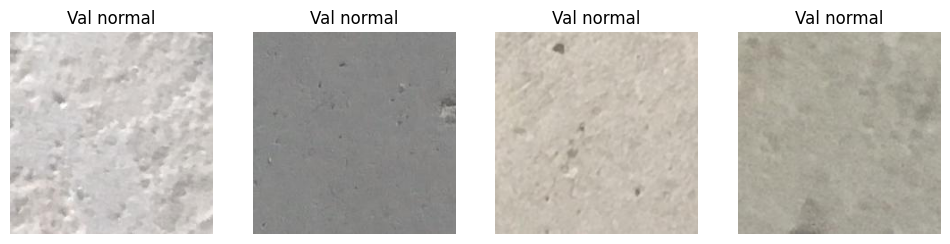

Val normal 총 이미지 수: 1700


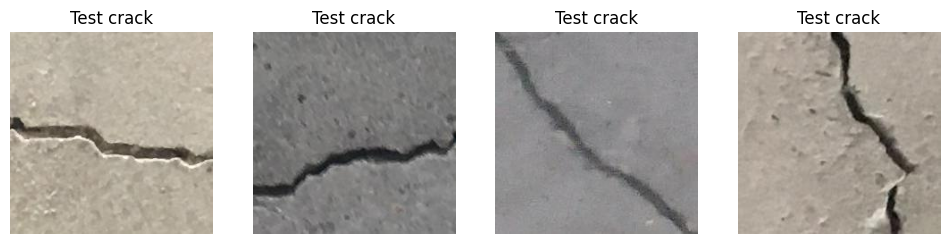

Test crack 총 이미지 수: 100


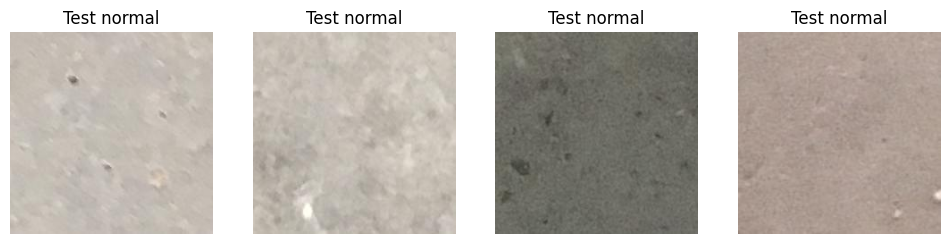

Test normal 총 이미지 수: 100


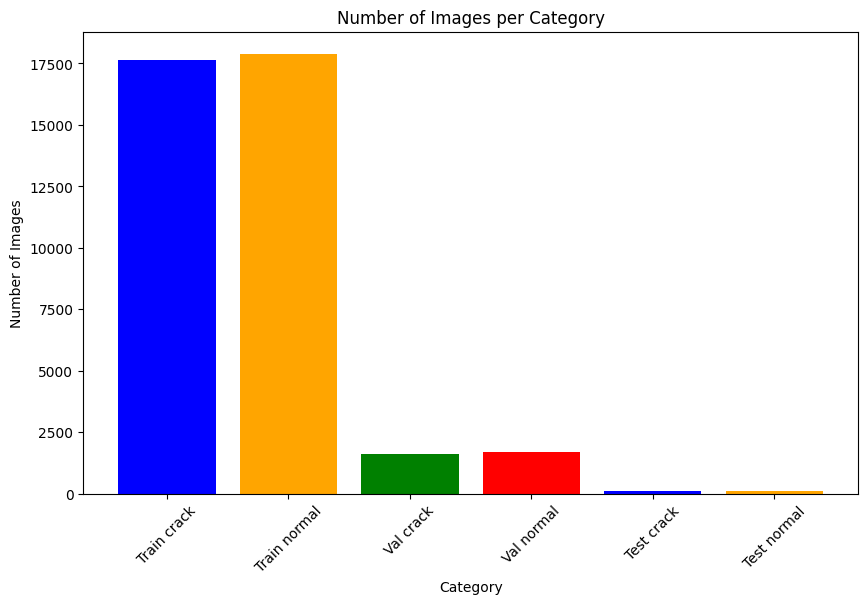

In [4]:

categories = ['Train crack', 'Train normal', 'Val crack', 'Val normal', 'Test crack', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/3/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/3/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [5]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_dataset = ImageFolder('/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/3/train', transform=transform)
val_dataset = ImageFolder('/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/3/val', transform=transform)

In [6]:
from torch.utils.data import SubsetRandomSampler
import numpy as np

num_of_train = 34550
num_of_val = 3300
train_indices = list(range(num_of_train))
val_indices = list(range(num_of_val))

np.random.shuffle(train_indices)
train_subset_indices = train_indices[:200]

np.random.shuffle(val_indices)
val_subset_indices = val_indices[:20]

train_sampler = SubsetRandomSampler(train_subset_indices)
val_sampler = SubsetRandomSampler(val_subset_indices)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, sampler=val_sampler)

### VGG 모델 로드 및 네트워크 구조 확인

In [7]:

net = models.vgg19(pretrained=True)
net

/opt/anaconda3/envs/imagebinary/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/imagebinary/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/taeyoun/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### 모델의 모든 파라미터를 고정

In [8]:

for param in net.parameters():
    param.requires_grad = False

### 모델 수정하기 Binary Classification Task에 맞게 교체

In [9]:

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True

In [10]:

criterion = nn.CrossEntropyLoss()

In [11]:
import torch.optim as optim

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train() 
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        net.eval()  
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [12]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', net, train_loader, val_loader, criterion)

[SGD] Epoch 1, Train Loss: 0.444300, Val Loss: 0.259436, Validation Accuracy: 90.00%
[SGD] Epoch 2, Train Loss: 0.196535, Val Loss: 0.253891, Validation Accuracy: 90.00%
[SGD] Epoch 3, Train Loss: 0.152732, Val Loss: 0.202837, Validation Accuracy: 90.00%
[SGD] Epoch 4, Train Loss: 0.108605, Val Loss: 0.172554, Validation Accuracy: 95.00%
[SGD] Epoch 5, Train Loss: 0.118258, Val Loss: 0.115896, Validation Accuracy: 95.00%
[SGD] Epoch 6, Train Loss: 0.083504, Val Loss: 0.164724, Validation Accuracy: 95.00%
[SGD] Epoch 7, Train Loss: 0.106089, Val Loss: 0.122512, Validation Accuracy: 95.00%
[SGD] Epoch 8, Train Loss: 0.098267, Val Loss: 0.108902, Validation Accuracy: 95.00%
[SGD] Epoch 9, Train Loss: 0.086377, Val Loss: 0.092700, Validation Accuracy: 95.00%
[SGD] Epoch 10, Train Loss: 0.075776, Val Loss: 0.105869, Validation Accuracy: 95.00%
[SGD] Epoch 11, Train Loss: 0.092930, Val Loss: 0.101613, Validation Accuracy: 95.00%
[SGD] Epoch 12, Train Loss: 0.080038, Val Loss: 0.107873, Valid

In [13]:

net = models.vgg19(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True

In [14]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.488937, Val Loss: 0.308559, Validation Accuracy: 95.00%
[Adam] Epoch 2, Train Loss: 0.151280, Val Loss: 0.162352, Validation Accuracy: 95.00%
[Adam] Epoch 3, Train Loss: 0.123326, Val Loss: 0.151104, Validation Accuracy: 95.00%
[Adam] Epoch 4, Train Loss: 0.107036, Val Loss: 0.156090, Validation Accuracy: 95.00%
[Adam] Epoch 5, Train Loss: 0.080625, Val Loss: 0.184206, Validation Accuracy: 95.00%
[Adam] Epoch 6, Train Loss: 0.092112, Val Loss: 0.150739, Validation Accuracy: 95.00%
[Adam] Epoch 7, Train Loss: 0.081898, Val Loss: 0.117661, Validation Accuracy: 95.00%
[Adam] Epoch 8, Train Loss: 0.070061, Val Loss: 0.105088, Validation Accuracy: 95.00%
[Adam] Epoch 9, Train Loss: 0.068905, Val Loss: 0.102920, Validation Accuracy: 95.00%
[Adam] Epoch 10, Train Loss: 0.052116, Val Loss: 0.120853, Validation Accuracy: 95.00%
[Adam] Epoch 11, Train Loss: 0.061612, Val Loss: 0.090080, Validation Accuracy: 95.00%
[Adam] Epoch 12, Train Loss: 0.069875, Val Loss: 0.1

In [15]:

net = models.vgg19(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True

In [16]:
train_losses_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.722878, Val Loss: 0.728766, Validation Accuracy: 40.00%
[RAdam] Epoch 2, Train Loss: 0.615508, Val Loss: 0.574471, Validation Accuracy: 80.00%
[RAdam] Epoch 3, Train Loss: 0.460072, Val Loss: 0.441702, Validation Accuracy: 90.00%
[RAdam] Epoch 4, Train Loss: 0.390544, Val Loss: 0.395039, Validation Accuracy: 90.00%
[RAdam] Epoch 5, Train Loss: 0.295759, Val Loss: 0.348725, Validation Accuracy: 90.00%
[RAdam] Epoch 6, Train Loss: 0.245567, Val Loss: 0.300155, Validation Accuracy: 95.00%
[RAdam] Epoch 7, Train Loss: 0.201769, Val Loss: 0.294808, Validation Accuracy: 95.00%
[RAdam] Epoch 8, Train Loss: 0.181013, Val Loss: 0.251715, Validation Accuracy: 95.00%
[RAdam] Epoch 9, Train Loss: 0.164220, Val Loss: 0.206170, Validation Accuracy: 95.00%
[RAdam] Epoch 10, Train Loss: 0.144141, Val Loss: 0.231592, Validation Accuracy: 95.00%
[RAdam] Epoch 11, Train Loss: 0.137375, Val Loss: 0.184993, Validation Accuracy: 95.00%
[RAdam] Epoch 12, Train Loss: 0.119901, V

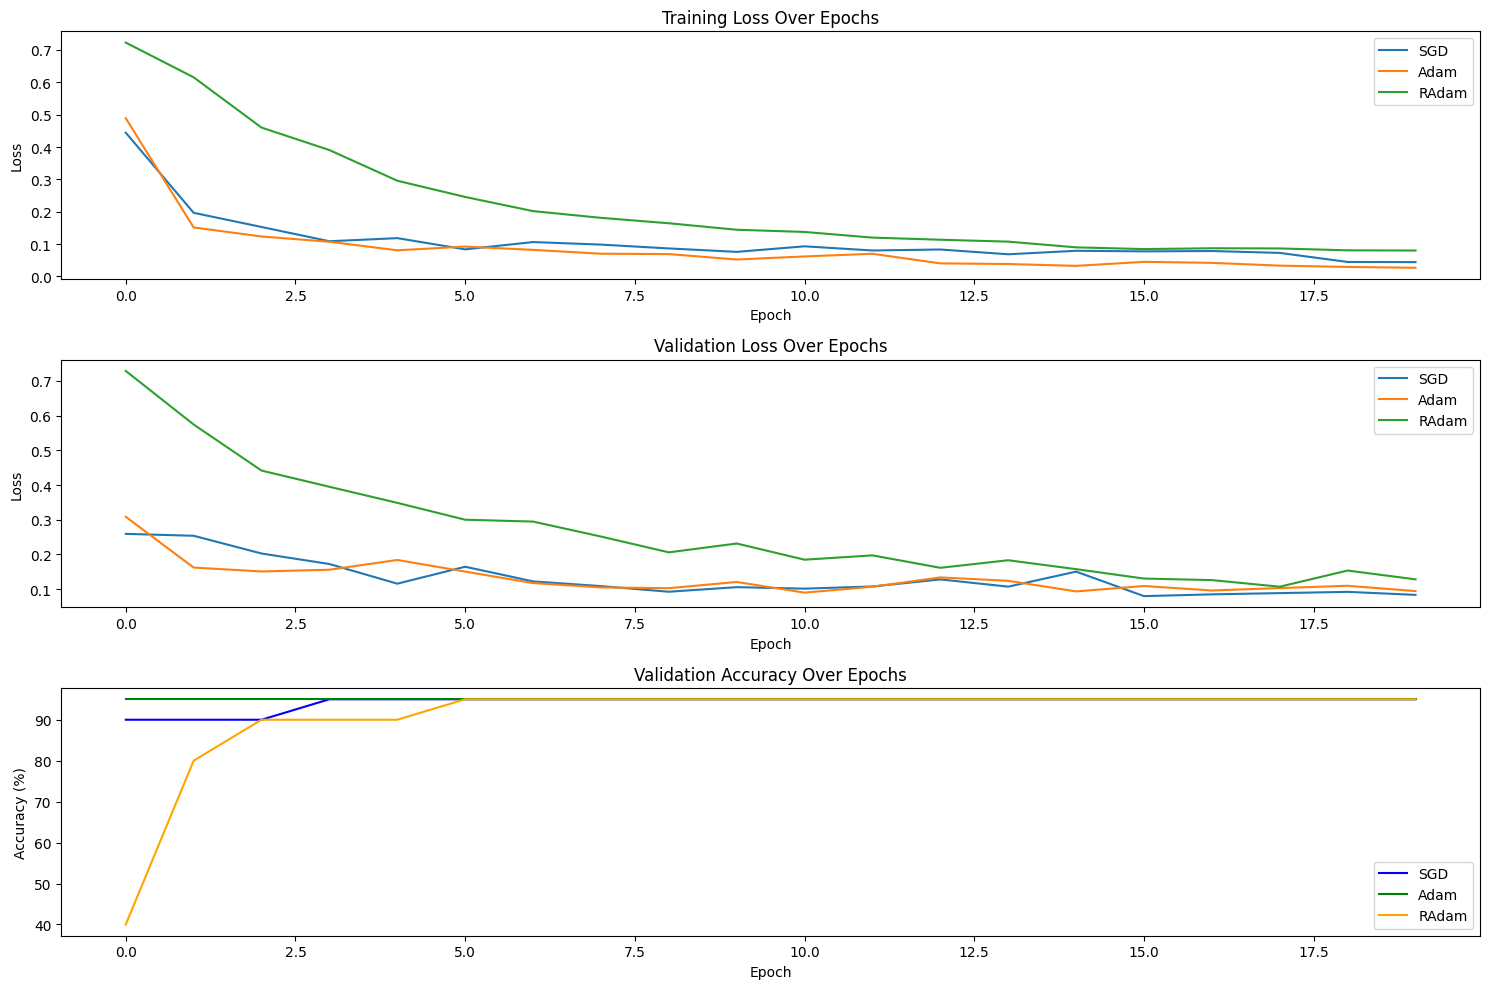

In [17]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)  
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2) 
plt.plot(val_losses_SGD, label='SGD')
plt.plot(val_losses_Adam, label='Adam')
plt.plot(val_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)  
plt.plot(val_accuracies_SGD, label='SGD', color='blue')
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.plot(val_accuracies_RAdam, label='RAdam', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:

def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  

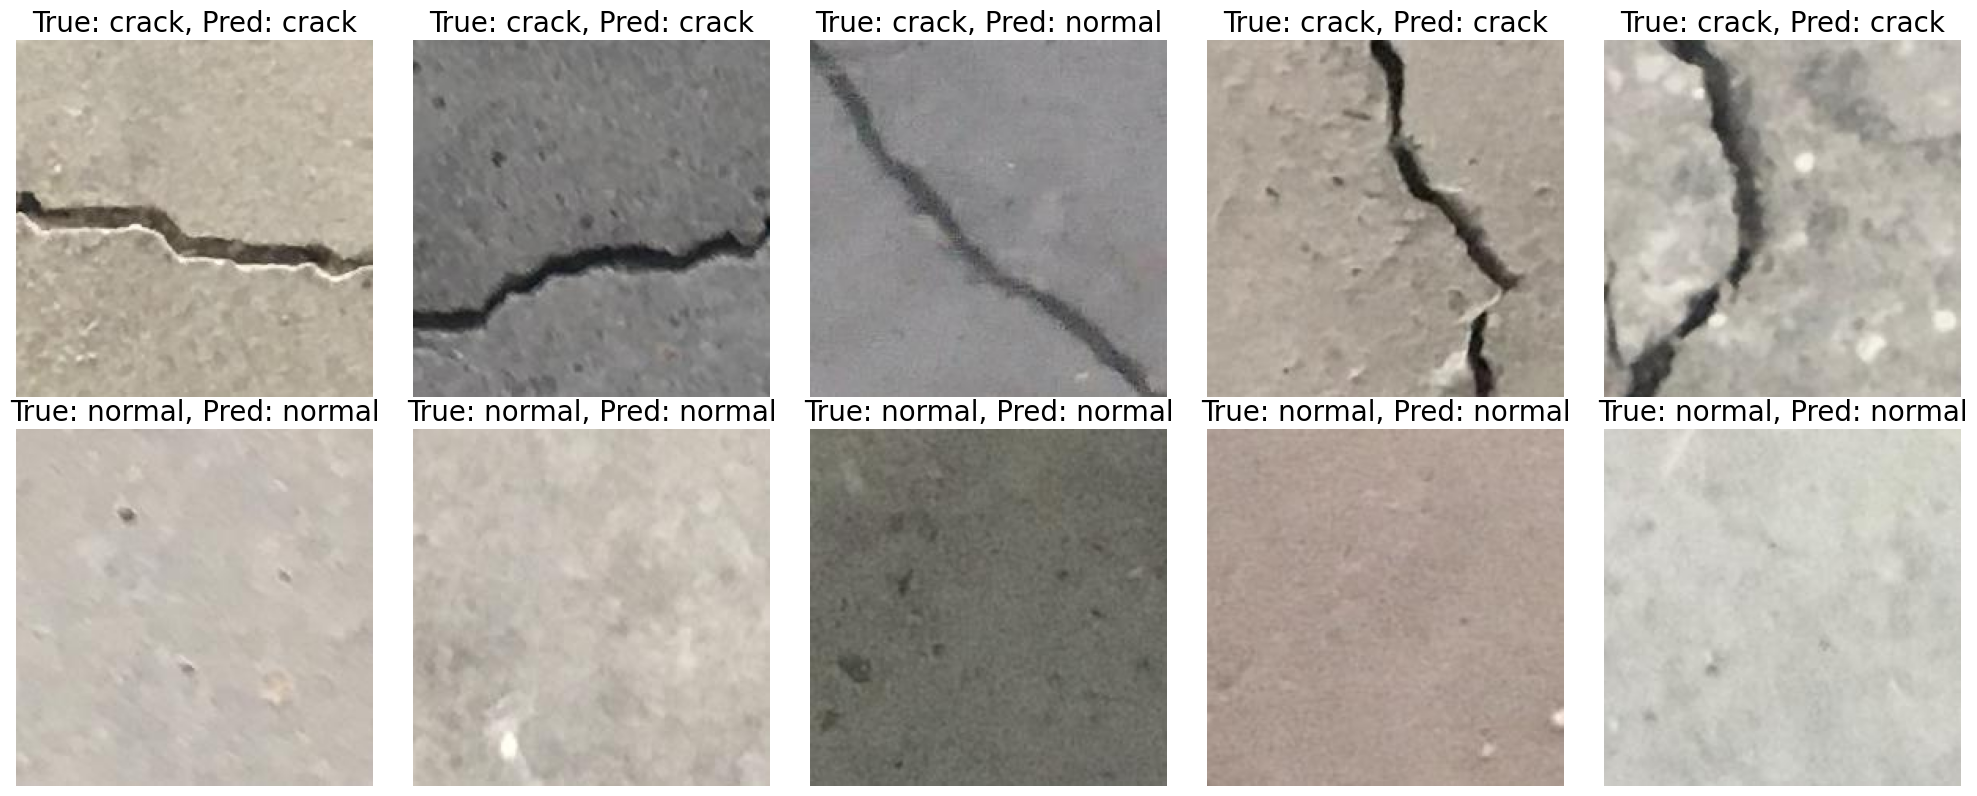

In [20]:

class_folders = {
    'crack': '//Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/3/test/crack',
    'normal': '/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/3/test/normal'
}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        net.eval()  
        with torch.no_grad():
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)
        prediction = 'crack' if predicted.item() == 0 else 'normal'

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}', fontsize=20)
        plt.axis('off')

        counter += 1 

plt.tight_layout()
plt.show()